In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import itertools

# Models that we will try
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

# Preprocessing tools
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Measuaring tools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import log_loss

# Cross Validation 
from sklearn.model_selection import train_test_split

# We are going to use one of sklearn datasets for this one
from sklearn import datasets

#Graphing tools
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

# The dataset we are about to use is fairly large in features thus it requires some preprocessing. We will use this opportunity to familiarize ourselves a bit more with PCA and then use it for our classification models.

## Step 1: Open dataset and only select those faces for which we have 70 or more images.

In [3]:
lfw = datasets.fetch_lfw_people(min_faces_per_person=70, 
                                resize=0.4,
                                data_home='datasets')
lfw.data.shape

(1288, 1850)

## Step 2: Print a few of the faces to familiarized yourself with the data.

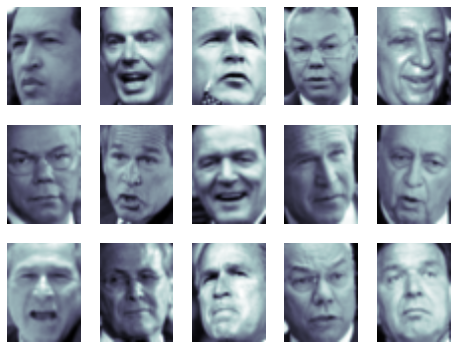

In [4]:
fig = plt.figure(figsize=(8, 6))
# plot several images
for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(lfw.images[i], cmap=plt.cm.bone)

## Step 3: Graph the different labels vs their count.

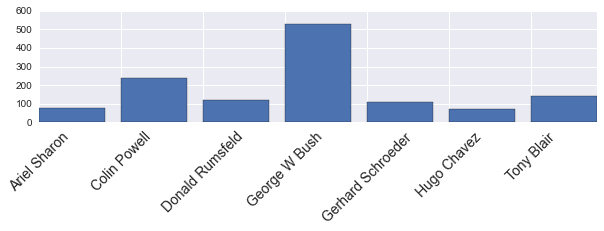

In [38]:
plt.figure(figsize=(10, 2))

unique_targets = np.unique(lfw.target)
counts = [(lfw.target == i).sum() for i in unique_targets]

plt.xticks(unique_targets, lfw.target_names[unique_targets])
locs, labels = plt.xticks()
plt.setp(labels, rotation=45, size=14)
_ = plt.bar(unique_targets, counts)

### Lets split our data into training and testing sets.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(lfw.data,
                                                    lfw.target,
                                                    random_state=0)

In [51]:
X_train.shape

(966, 1850)

## Step 4: Notice that the number of features in our dataset is fairly large. This is a good moment to apply PCA to reduce the dimensionality of our dataset. Lets choose 150 components.

In [10]:
pca = PCA(n_components=150,svd_solver='randomized', whiten=True)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

## Step 5: A really cool thing about PCA is that it lets you compute the mean of each entry which we can then use to obtain the 'average' face in our dataset.

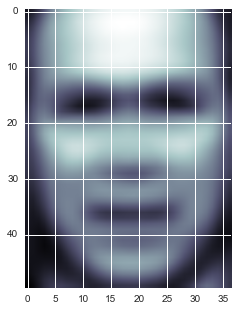

In [53]:
plt.imshow(pca.mean_.reshape((50, 37)), cmap=plt.cm.bone)

### It looks like George W. Bush!

## Step 6: Plot the components of the PCA. Notice that these are always ordered by importance.

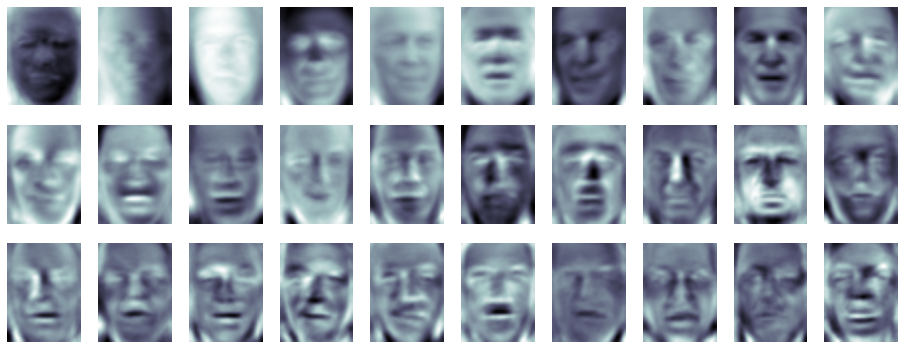

In [54]:
fig = plt.figure(figsize=(16, 6))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape((50, 37)), cmap=plt.cm.bone)

### As you can see the first few components are very good at picking up lighting and the others seem to be identifying things like the nose, eyes or mouth shape.

# Exercise 2:

### Logistic Regression

In [11]:
lreg = LogisticRegression()

In [13]:
lreg.fit(X_train_pca, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [14]:
lreg.score(X_test_pca, y_test)

0.79503105590062106

### kNeighbors Classifier

In [108]:
# Lets search for the best 'k' value for the classifier
a = 0
score = 0
for i in range(2, 10):
    kNC = KNeighborsClassifier(n_neighbors=i)
    kNC.fit(X_train_pca, y_train)
    temp = kNC.score(X_test_pca, y_test)
    if temp > score:
        a = i
        score = temp
print("The best n_neighbors is {} with a mean accuracy of {}".format(a, score))
print('\n')
print(KNeighborsClassifier(n_neighbors=a))

The best n_neighbors is 5 with a mean accuracy of 0.7142857142857143


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')


### Linear Discriminant

In [31]:
LD = LinearDiscriminantAnalysis()

In [32]:
LD.fit(X_train_pca, y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [33]:
LD.score(X_test_pca, y_test)

0.82608695652173914

### Naive Bayes

In [39]:
nb = GaussianNB()

In [40]:
nb.fit(X_train_pca, y_train)

GaussianNB(priors=None)

In [41]:
nb.score(X_test_pca, y_test)

0.69875776397515532

### Naive Bayes < KNeighborsClassifier < Logistic Regression < Linear Discriminant

### Part 2: Which one had the best performance? Which one had the worst performance?

Linear Discriminant discriminant had the best performance with an 83% accuracy. Naive Bayes had the worst performance with a 70% accuracy.

### Part 3: Any idea why the score on the top two differs so drastically from the last two?

One thing that is worth noticing is that the top two models are based more on linear relations (Linear Discriminant and Logistic Regression) while Naive Bayes assumes independence of features.

### Part 4: Find the log_loss, precision, recall, f_score of the best model.

In [112]:
log_loss(y_test, LD.predict_proba(X_test_pca))

0.68190856584734494

In [119]:
precision_recall_fscore_support(y_test, LD.predict(X_test_pca), average='weighted')

(0.83180901859391565, 0.82608695652173914, 0.82537159666163962, None)

### Part 5: Plot the Confusion Matrix of the best model.

Confusion matrix


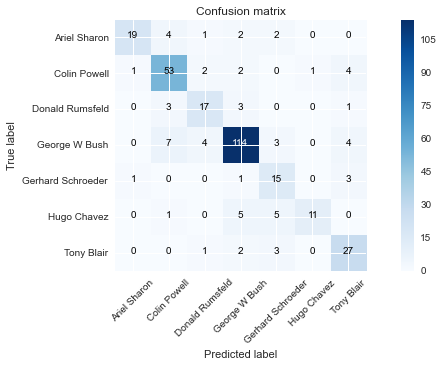

In [68]:
y_pred = lreg.predict(X_test_pca)
class_names = lfw.target_names
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    print('Confusion matrix')
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')

plt.show()

## Part 6 (optional): Edit the code from *Step 2* to display not only the image but also the label and color code the label in red if your model got it wrong or black if it got it right.

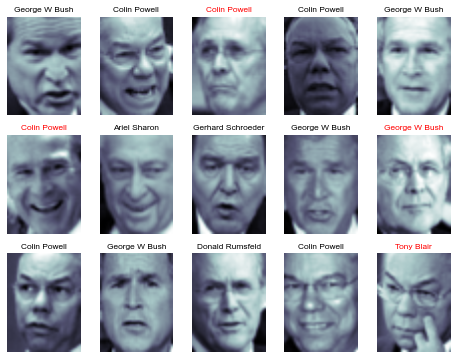

In [56]:
fig = plt.figure(figsize=(8, 6))
for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(X_test[i].reshape((50, 37)), cmap=plt.cm.bone)
    y_pred = lreg.predict(X_test_pca[i].reshape(1, -1))[0]
    color = 'black' if y_pred == np.array(y_test[i]) else 'red'
    ax.set_title(lfw.target_names[y_pred], fontsize='small', color=color)